# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\sujpanda\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\sujpanda\\Desktop\\applied\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[10]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[15]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[49]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
I've been trying to find the individual-pack option (at the affordable price) for months now. I love having the ability to know exactly how much creamer I'm using by counting the individual packets. (This product isn't available in my grocery store-- just by the coffee dispensers at local convenience stores.) They're perfect for keeping at my desk at work~~I don't have to use the community fridge, and it doesn't lump up in my coffee like the powdered versions do. It's a little less convenient at home, though, where I'm accustomed to using my refrigerated bottled versions~~opening the little packets one at a time at 5 am can get annoying--but then again, I know exactly ho

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
I've been trying to find the individual-pack option (at the affordable price) for months now. I love having the ability to know exactly how much creamer I'm using by counting the individual packets. (This product isn't available in my grocery store-- just by the coffee dispensers at local convenience stores.) They're perfect for keeping at my desk at work~~I don't have to use the community fridge, and it doesn't lump up in my coffee like the powdered versions do. It's a little less convenient at home, though, where I'm accustomed to using my refrigerated bottled versions~~opening the little packets one at a time at 5 am can get annoying--but then again, I know exactly ho

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is another favorite in our house.  My cat does not want it more than 4 times a month or so, but he still wants it and licks the bowl clean.  It is fish, not his favorite, but he really likes his salmon and this one is outstanding.  It is ground (why do not they make a sliced or bits version?), not his favorite either, but he does get it down pretty quickly.  Try this one - it is a definite winner.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is another favorite in our house My cat does not want it more than 4 times a month or so but he still wants it and licks the bowl clean It is fish not his favorite but he really likes his salmon and this one is outstanding It is ground why do not they make a sliced or bits version not his favorite either but he does get it down pretty quickly Try this one it is a definite winner 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:38<00:00, 1196.83it/s]


In [26]:
preprocessed_reviews[15]

'another favorite house cat not want times month still wants licks bowl clean fish not favorite really likes salmon one outstanding ground not make sliced bits version not favorite either get pretty quickly try one definite winner'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

 76%|███████▌  | 34822/46071 [00:15<00:04, 2498.73it/s]C:\Users\sujpanda\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 46071/46071 [00:21<00:00, 2102.01it/s]


## Some Utility functions

In [28]:
def get_optimum_k(X_train,X_test,y_train,y_test,test_size,algorithm):

    f1_scores =[]

    max_accuracy = 0
    optimum_k = 0
    i = 0
    for i in range(1,30,2):
        # instantiate learning model (k = 30)
        knn = KNeighborsClassifier(n_neighbors=i,algorithm=algorithm)

        # fitting the model on crossvalidation train
        knn.fit(X_train, y_train)

        # predict the response on the crossvalidation train
        pred = knn.predict(X_test)

        # evaluate CV accuracy
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
        f1_score = f1_score(y_test, pred)*100
        f1_scores.append(f1_score)
        #acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
        print('\nCV f1 score for k = %d is %d%%' % (i, f1_score))
        if int(f1_score) > max_accuracy:
            max_accuracy = int(f1_score)
            optimum_k = i 
    
    print('\nCV with Max f1 score for k = %d is %d%%' % (optimum_k, max_accuracy))
    print(f1_scores)
    MSE = [1 - x for x in f1_scores]
    myList = list(range(0,30))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))
    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))

    return optimum_k

In [29]:
def knn_results(optimum_n,algorithm_to_choose,X_train,X_test,y_train,y_test):
    # roc curve and auc
    from sklearn.datasets import make_classification
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from matplotlib import pyplot
    # ============================== KNN with k = optimal_k ===============================================
    # instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=optimum_n,algorithm=algorithm_to_choose)

    # fitting the model
    knn_optimal.fit(X_train, y_train)

    # predict the response
    pred = knn_optimal.predict(X_test)

    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimum_n, acc))

    probs = knn_optimal.predict_proba(X_test)
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    # show the plot
    pyplot.show()
    from sklearn.metrics import confusion_matrix
    con_mat = confusion_matrix(y_test, pred, [0, 1])
    return con_mat

In [30]:
def showHeatMap(con_mat):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(con_mat, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [39]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
    from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")


In [40]:
print(final['Text'].shape)

(46071,)


In [41]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

Note: There is chance of data leakage in case we vectorize the whole dataset. To avoid that first split the data then fit_transform the trainging data and only transform the test data.


CV f1 score for k = 1 is 87%

CV f1 score for k = 3 is 89%

CV f1 score for k = 5 is 90%

CV f1 score for k = 7 is 90%

CV f1 score for k = 9 is 90%

CV f1 score for k = 11 is 90%

CV f1 score for k = 13 is 90%

CV f1 score for k = 15 is 90%

CV f1 score for k = 17 is 90%

CV f1 score for k = 19 is 90%

CV f1 score for k = 21 is 90%

CV f1 score for k = 23 is 90%

CV f1 score for k = 25 is 90%

CV f1 score for k = 27 is 90%

CV f1 score for k = 29 is 90%

CV with Max f1 score for k = 5 is 90%
[87.20396548558841, 89.68827782387106, 90.56295258117262, 90.71470075537479, 90.87536231884059, 90.88383399895817, 90.94169366034244, 90.8680816609797, 90.78620530298655, 90.81567857761357, 90.8692138981877, 90.8052607291186, 90.78120495820123, 90.82838531158126, 90.83472550262113]


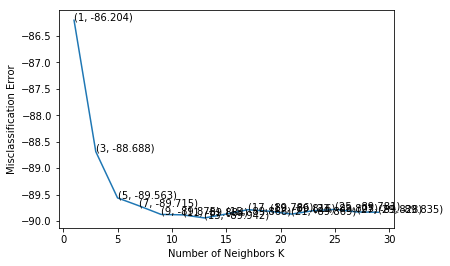

the misclassification error for each k value is :  [-86.204 -88.688 -89.563 -89.715 -89.875 -89.884 -89.942 -89.868 -89.786
 -89.816 -89.869 -89.805 -89.781 -89.828 -89.835]


In [190]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_1)
final_test_count = count_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = count_vect.transform(X_tr)
final_test_count_cv = count_vect.transform(X_cv)

optimum_k=get_optimum_k(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv,0.3,'brute')

Observation: From the plot it is obivous that K=5 is the optimum value. After this if we change the K value it is not going to reduce the error further.


The accuracy of the knn classifier for k = 5 is 83.150051%
AUC: 0.645


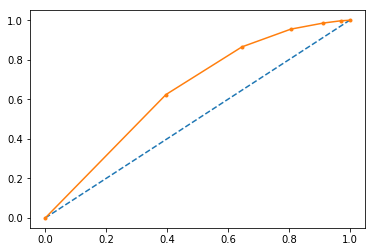

In [191]:
con_mat=knn_results(optimum_k,'brute',final_counts,final_test_count,y_1,y_test)

Observation: My AUC is 0.645 means my model is performing better than the dumb model.

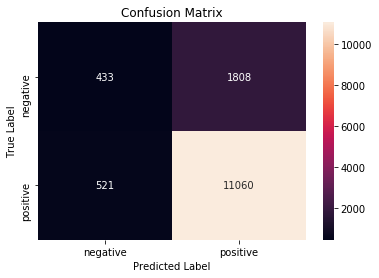

In [192]:
showHeatMap(con_mat)

Observation : My model predicted 1808 + 521 = 2329 points wrongly.

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [193]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)


CV f1 score for k = 1 is 90%

CV f1 score for k = 3 is 91%

CV f1 score for k = 5 is 91%

CV f1 score for k = 7 is 91%

CV f1 score for k = 9 is 91%

CV f1 score for k = 11 is 90%

CV f1 score for k = 13 is 90%

CV f1 score for k = 15 is 90%

CV f1 score for k = 17 is 90%

CV f1 score for k = 19 is 90%

CV f1 score for k = 21 is 90%

CV f1 score for k = 23 is 90%

CV f1 score for k = 25 is 90%

CV f1 score for k = 27 is 90%

CV f1 score for k = 29 is 90%

CV with Max f1 score for k = 3 is 91%
[90.98198656050596, 91.02694172021192, 91.01155255001409, 91.00230998929517, 91.0033237564081, 90.99819738621, 90.99819738621, 90.99819738621, 90.99819738621, 90.99819738621, 90.99819738621, 90.99819738621, 90.99819738621, 90.99819738621, 90.99819738621]


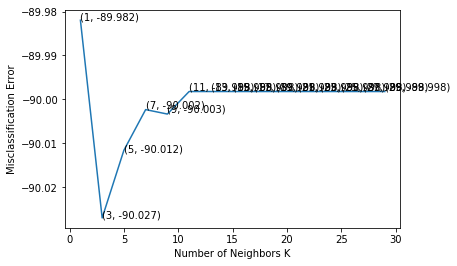

the misclassification error for each k value is :  [-89.982 -90.027 -90.012 -90.002 -90.003 -89.998 -89.998 -89.998 -89.998
 -89.998 -89.998 -89.998 -89.998 -89.998 -89.998]


In [194]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_1)
final_tf_idf = tf_idf_vect.transform(X_1)
final_test_count = tf_idf_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = tf_idf_vect.transform(X_tr)
final_test_count_cv = tf_idf_vect.transform(X_cv)

optimum_k=get_optimum_k(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv,0.3,'brute')

Observation: From the plot it is obivious that K = 3 is optimum with maximum accuracy.


The accuracy of the knn classifier for k = 3 is 83.772247%
AUC: 0.509


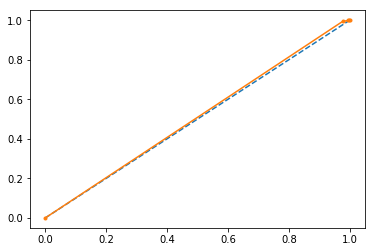

In [195]:
con_mat=knn_results(optimum_k,'brute',final_tf_idf,final_test_count,y_1,y_test)

Observation : TFIDF model is as dumb as my dumb model and accuracy is very low.

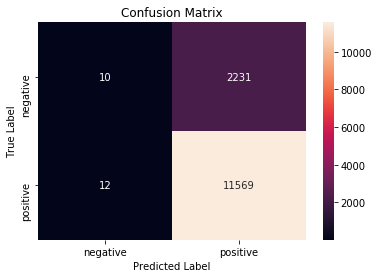

In [196]:
showHeatMap(con_mat)

Obseration: My model predict most of the negative points as positive (2231). So model is more biased towards +ve points.

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [42]:
# split the data set into train and test
X_train, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)


In [43]:
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())
    
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    #print(w2v_model.wv.most_similar('great'))
    #print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #print(w2v_model.wv.most_similar('great'))
        #print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
        
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])




# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

number of words that occured minimum 5 times  10772
sample words  ['three', 'cats', 'kitty', 'notoriously', 'fussy', 'eaters', 'although', 'eat', 'dry', 'food', 'not', 'especially', 'pleased', 'willing', 'kit', 'n', 'favor', 'purina', 'products', 'one', 'two', 'things', 'going', 'price', 'right', 'dogs', 'also', 'give', 'paws', 'little', 'sneaks', 'hi', 'would', 'better', 'sweet', 'aftertaste', 'tastes', 'like', 'saccharin', 'bit', 'overpowering', 'excited', 'saw', 'vintage', 'cracker', 'jack', 'box', 'read', 'review', 'arrived']


100%|██████████| 32249/32249 [01:41<00:00, 317.14it/s]


32249
50


In [44]:
#working with test data to get the sentence vector and traind the model with w2vec
i=0
list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())
    
    
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_test_sentance,min_count=5,size=50, workers=4)
    #print(w2v_model.wv.most_similar('great'))
    #print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #print(w2v_model.wv.most_similar('great'))
        #print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
        
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# average Word2Vec
# compute average word2vec for each review.
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))


number of words that occured minimum 5 times  7102
sample words  ['wow', 'lobster', 'spreads', 'quite', 'treat', 'try', 'good', 'hard', 'cheese', 'mild', 'crackers', 'sweet', 'taste', 'delicious', 'melts', 'mouth', 'not', 'available', 'markets', 'dolce', 'coffee', 'maker', 'love', 'unfortunately', 'area', 'buy', 'flavored', 'coffees', 'thank', 'handling', 'machine', 'favorite', 'lungo', 'espresso', 'several', 'cups', 'day', 'many', 'miracle', 'health', 'products', 'know', 'real', 'enough', 'people', 'said', 'things', 'seeds', 'decided', 'jump']


100%|██████████| 13822/13822 [00:31<00:00, 434.58it/s]


13822
50



CV f1 score for k = 1 is 89%

CV f1 score for k = 3 is 91%

CV f1 score for k = 5 is 91%

CV f1 score for k = 7 is 92%

CV f1 score for k = 9 is 92%

CV f1 score for k = 11 is 92%

CV f1 score for k = 13 is 92%

CV f1 score for k = 15 is 92%

CV f1 score for k = 17 is 92%

CV f1 score for k = 19 is 92%

CV f1 score for k = 21 is 92%

CV f1 score for k = 23 is 92%

CV f1 score for k = 25 is 92%

CV f1 score for k = 27 is 92%

CV f1 score for k = 29 is 92%

CV with Max f1 score for k = 7 is 92%
[89.40972222222221, 91.33192389006342, 91.9083786854853, 92.16140726213823, 92.25293629137504, 92.25035494557501, 92.32131263648705, 92.3675369835563, 92.32308960320263, 92.3909208514642, 92.42424242424242, 92.44032608058178, 92.45736388677255, 92.50776170113055, 92.49516667643096]


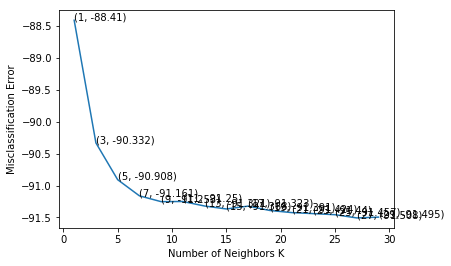

the misclassification error for each k value is :  [-88.41  -90.332 -90.908 -91.161 -91.253 -91.25  -91.321 -91.368 -91.323
 -91.391 -91.424 -91.44  -91.457 -91.508 -91.495]


In [200]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(sent_vectors, y_1, test_size=0.3)

optimum_k=get_optimum_k(X_tr,X_cv,y_tr,y_cv,0.3,'brute')

Observation: For k=7 gives most accuracy. After increasing k does not affect much.


The accuracy of the knn classifier for k = 7 is 82.397627%
AUC: 0.696


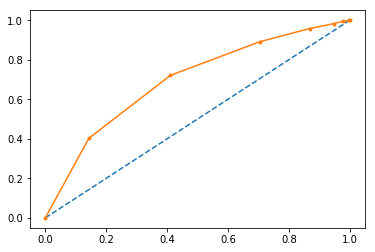

In [201]:
con_mat=knn_results(optimum_k,'brute',sent_vectors,sent_test_vectors,y_1,y_test)

Observation: My model preformed better in this case with auc of 0.696.

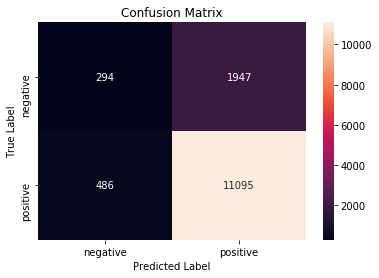

In [202]:
showHeatMap(con_mat)

Observation : My model misclassified 586 + 1947 data points. 

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [45]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")

X_train, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

model = TfidfVectorizer()
X_train = model.fit_transform(X_train)
X_test = model.transform(X_test)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    


100%|██████████| 32249/32249 [22:02<00:00, 24.38it/s]


In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1
    


100%|██████████| 13822/13822 [10:16<00:00, 22.42it/s]



CV f1 score for k = 1 is 87%

CV f1 score for k = 3 is 89%

CV f1 score for k = 5 is 90%

CV f1 score for k = 7 is 91%

CV f1 score for k = 9 is 91%

CV f1 score for k = 11 is 91%

CV f1 score for k = 13 is 91%

CV f1 score for k = 15 is 91%

CV f1 score for k = 17 is 91%

CV f1 score for k = 19 is 91%

CV f1 score for k = 21 is 91%

CV f1 score for k = 23 is 91%

CV f1 score for k = 25 is 91%

CV f1 score for k = 27 is 91%

CV f1 score for k = 29 is 91%

CV with Max f1 score for k = 7 is 91%
[87.5208603745596, 89.79762402244643, 90.72711215778628, 91.26622237811294, 91.36318754719174, 91.48517145505097, 91.60314160314161, 91.66906889593544, 91.6887302866352, 91.70832615066368, 91.74269811212487, 91.71061683100207, 91.70821156380724, 91.73208044462268, 91.72536219435378]


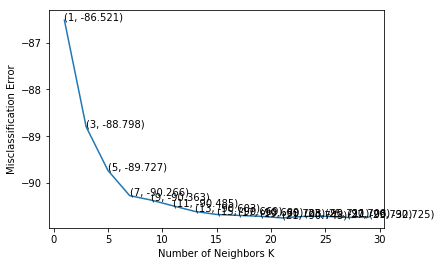

the misclassification error for each k value is :  [-86.521 -88.798 -89.727 -90.266 -90.363 -90.485 -90.603 -90.669 -90.689
 -90.708 -90.743 -90.711 -90.708 -90.732 -90.725]


In [48]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(tfidf_sent_vectors, y_1, test_size=0.3)

optimum_k=get_optimum_k(X_tr,X_cv,y_tr,y_cv,0.3,'brute')

Observation: For k=7 gives most accuracy. After increasing k does not affect much.


The accuracy of the knn classifier for k = 7 is 84.322095%
AUC: 0.746


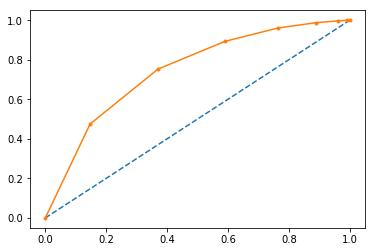

In [49]:
con_mat=knn_results(optimum_k,'brute',tfidf_sent_vectors,tfidf_test_sent_vectors,y_1,y_test)

Observation: My model preformed better in this case with auc of 0.746.

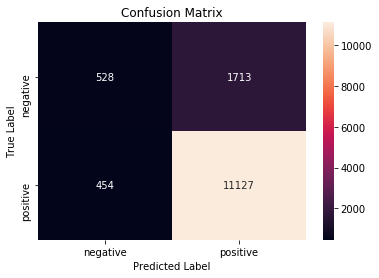

In [50]:
showHeatMap(con_mat)

Observation : My model misclassified 454 + 1713 data points. Better than w2vec.

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [51]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)



CV f1 score for k = 1 is 85%

CV f1 score for k = 3 is 88%

CV f1 score for k = 5 is 89%

CV f1 score for k = 7 is 90%

CV f1 score for k = 9 is 90%

CV f1 score for k = 11 is 90%

CV f1 score for k = 13 is 90%

CV f1 score for k = 15 is 90%

CV f1 score for k = 17 is 90%

CV f1 score for k = 19 is 90%

CV f1 score for k = 21 is 90%

CV f1 score for k = 23 is 90%

CV f1 score for k = 25 is 90%

CV f1 score for k = 27 is 90%

CV f1 score for k = 29 is 90%

CV with Max f1 score for k = 7 is 90%
[85.14245649818344, 88.23529411764704, 89.35452793834297, 90.00716332378222, 90.31644063763979, 90.47957371225577, 90.44074205364527, 90.56981398634328, 90.64832774936814, 90.68935171604576, 90.77175313268533, 90.83786470209905, 90.89209557749605, 90.94729469444931, 90.84650837174027]


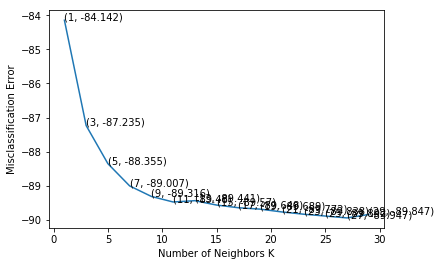

the misclassification error for each k value is :  [-84.142 -87.235 -88.355 -89.007 -89.316 -89.48  -89.441 -89.57  -89.648
 -89.689 -89.772 -89.838 -89.892 -89.947 -89.847]


In [52]:
count_vect = CountVectorizer(min_df=10, max_features=500)
final_counts = count_vect.fit_transform(X_1)
final_test_count = count_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = count_vect.transform(X_tr)
final_test_count_cv = count_vect.transform(X_cv)

optimum_k=get_optimum_k(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv,0.3,'kd_tree')

Observation: For k=7 gives most accuracy. After increasing k does not affect much.


The accuracy of the knn classifier for k = 7 is 83.012589%
AUC: 0.729


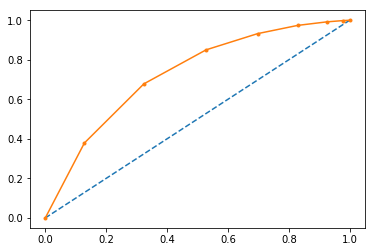

In [53]:
con_mat=knn_results(optimum_k,'kd_tree',final_counts,final_test_count,y_1,y_test)

Observation: My model preformed better in this case with auc of 0.729.

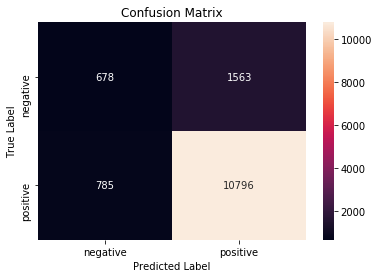

In [54]:
showHeatMap(con_mat)

Observation : My model misclassified 785 + 1563 data points.

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [55]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)


CV f1 score for k = 1 is 88%

CV f1 score for k = 3 is 90%

CV f1 score for k = 5 is 90%

CV f1 score for k = 7 is 90%

CV f1 score for k = 9 is 90%

CV f1 score for k = 11 is 90%

CV f1 score for k = 13 is 90%

CV f1 score for k = 15 is 90%

CV f1 score for k = 17 is 90%

CV f1 score for k = 19 is 90%

CV f1 score for k = 21 is 90%

CV f1 score for k = 23 is 90%

CV f1 score for k = 25 is 90%

CV f1 score for k = 27 is 90%

CV f1 score for k = 29 is 90%

CV with Max f1 score for k = 3 is 90%
[88.89946460440214, 90.38772213247172, 90.62589474889768, 90.82840236686391, 90.89671601157052, 90.9235037653587, 90.91731704558308, 90.92039098254139, 90.90909090909092, 90.90088055994582, 90.88549015181444, 90.89061970877074, 90.88036117381489, 90.86497771257687, 90.8660084626234]


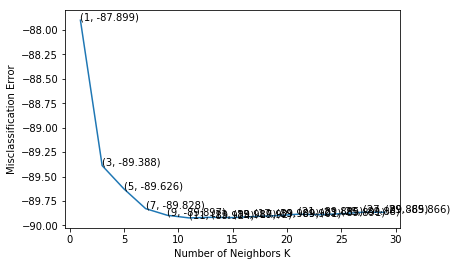

the misclassification error for each k value is :  [-87.899 -89.388 -89.626 -89.828 -89.897 -89.924 -89.917 -89.92  -89.909
 -89.901 -89.885 -89.891 -89.88  -89.865 -89.866]


In [56]:
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect.fit(X_1)
final_tf_idf = tf_idf_vect.transform(X_1)
final_test_count = tf_idf_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = tf_idf_vect.transform(X_tr)
final_test_count_cv = tf_idf_vect.transform(X_cv)

optimum_k=get_optimum_k(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv,0.3,'kd_tree')


Observation: For k=3 gives most accuracy. After increasing k does not affect much.


The accuracy of the knn classifier for k = 3 is 83.236869%
AUC: 0.595


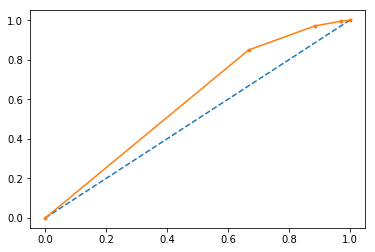

In [57]:
con_mat=knn_results(optimum_k,'kd_tree',final_tf_idf,final_test_count,y_1,y_test)

Observation: My model preformed not much better than the dumb model with auc 0.595.

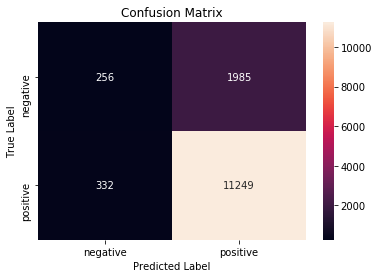

In [58]:
showHeatMap(con_mat)

Observation : 332 + 1985 points classifed wrongly.

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [59]:
X_train, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

In [60]:
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())
    
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    #print(w2v_model.wv.most_similar('great'))
    #print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #print(w2v_model.wv.most_similar('great'))
        #print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
        
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


number of words that occured minimum 5 times  10772
sample words  ['three', 'cats', 'kitty', 'notoriously', 'fussy', 'eaters', 'although', 'eat', 'dry', 'food', 'not', 'especially', 'pleased', 'willing', 'kit', 'n', 'favor', 'purina', 'products', 'one', 'two', 'things', 'going', 'price', 'right', 'dogs', 'also', 'give', 'paws', 'little', 'sneaks', 'hi', 'would', 'better', 'sweet', 'aftertaste', 'tastes', 'like', 'saccharin', 'bit', 'overpowering', 'excited', 'saw', 'vintage', 'cracker', 'jack', 'box', 'read', 'review', 'arrived']


In [61]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|██████████| 32249/32249 [01:48<00:00, 298.29it/s]


32249
50


In [62]:
#working with test data to get the sentence vector and traind the model with w2vec
i=0
list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())
    
    
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_test_sentance,min_count=5,size=50, workers=4)
    #print(w2v_model.wv.most_similar('great'))
    #print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #print(w2v_model.wv.most_similar('great'))
        #print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
        
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


number of words that occured minimum 5 times  7102
sample words  ['wow', 'lobster', 'spreads', 'quite', 'treat', 'try', 'good', 'hard', 'cheese', 'mild', 'crackers', 'sweet', 'taste', 'delicious', 'melts', 'mouth', 'not', 'available', 'markets', 'dolce', 'coffee', 'maker', 'love', 'unfortunately', 'area', 'buy', 'flavored', 'coffees', 'thank', 'handling', 'machine', 'favorite', 'lungo', 'espresso', 'several', 'cups', 'day', 'many', 'miracle', 'health', 'products', 'know', 'real', 'enough', 'people', 'said', 'things', 'seeds', 'decided', 'jump']


In [63]:
# average Word2Vec
# compute average word2vec for each review.
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))


100%|██████████| 13822/13822 [00:37<00:00, 370.82it/s]


13822
50



CV f1 score for k = 1 is 89%

CV f1 score for k = 3 is 91%

CV f1 score for k = 5 is 91%

CV f1 score for k = 7 is 92%

CV f1 score for k = 9 is 92%

CV f1 score for k = 11 is 92%

CV f1 score for k = 13 is 92%

CV f1 score for k = 15 is 92%

CV f1 score for k = 17 is 92%

CV f1 score for k = 19 is 92%

CV f1 score for k = 21 is 92%

CV f1 score for k = 23 is 92%

CV f1 score for k = 25 is 92%

CV f1 score for k = 27 is 92%

CV f1 score for k = 29 is 92%

CV with Max f1 score for k = 7 is 92%
[89.62246720453287, 91.39144558743908, 91.89028026237328, 92.27574750830566, 92.45952015128236, 92.63767430867406, 92.60548834464444, 92.70330704954691, 92.7360489757476, 92.71445358401881, 92.72705909998825, 92.69379617685, 92.69893355209187, 92.6335498215435, 92.6832123624444]


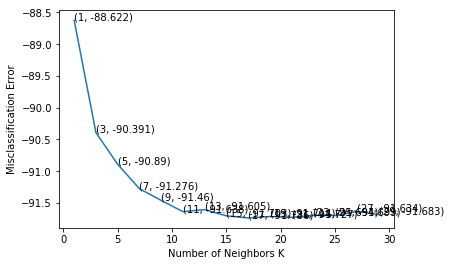

the misclassification error for each k value is :  [-88.622 -90.391 -90.89  -91.276 -91.46  -91.638 -91.605 -91.703 -91.736
 -91.714 -91.727 -91.694 -91.699 -91.634 -91.683]


In [64]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(sent_vectors, y_1, test_size=0.3)

optimum_k=get_optimum_k(X_tr,X_cv,y_tr,y_cv,0.3,'kd_tree')

Observation: For k=7 gives most accuracy. After increasing k does not affect much.


The accuracy of the knn classifier for k = 7 is 83.439444%
AUC: 0.695


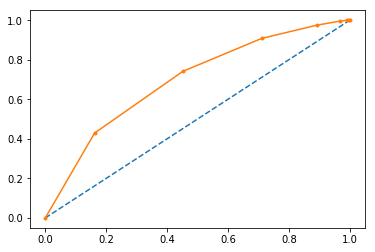

In [65]:
con_mat=knn_results(optimum_k,'kd_tree',sent_vectors,sent_test_vectors,y_1,y_test)

Observation: My model predicted with auc 0.695.

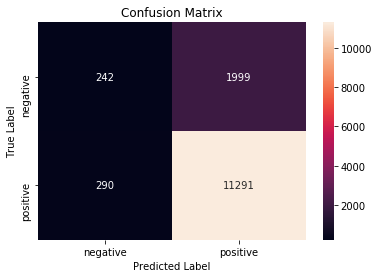

In [66]:
showHeatMap(con_mat)

Observation : 290 + 1999 points classifed wrongly.

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [72]:
X_train, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

model = TfidfVectorizer()
X_train = model.fit_transform(X_train)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

X_test = model.transform(X_test)

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1
    


CV f1 score for k = 1 is 87%

CV f1 score for k = 3 is 89%

CV f1 score for k = 5 is 90%

CV f1 score for k = 7 is 90%

CV f1 score for k = 9 is 91%

CV f1 score for k = 11 is 91%

CV f1 score for k = 13 is 91%

CV f1 score for k = 15 is 91%

CV f1 score for k = 17 is 91%

CV f1 score for k = 19 is 91%

CV f1 score for k = 21 is 91%

CV f1 score for k = 23 is 91%

CV f1 score for k = 25 is 91%

CV f1 score for k = 27 is 91%

CV f1 score for k = 29 is 91%

CV with Max f1 score for k = 9 is 91%
[87.2813004094801, 89.7934750074828, 90.4978444457568, 90.8952514784238, 91.1188811188811, 91.31292043609372, 91.3826031599051, 91.48567467652495, 91.4851941467911, 91.52425340928707, 91.52152670000574, 91.46761598530088, 91.54565803822534, 91.5944689884675, 91.56626506024097]


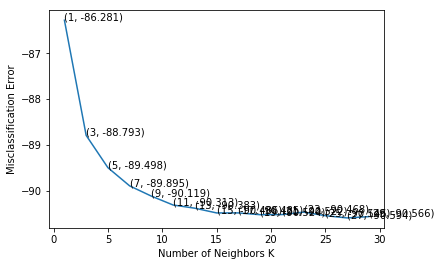

the misclassification error for each k value is :  [-86.281 -88.793 -89.498 -89.895 -90.119 -90.313 -90.383 -90.486 -90.485
 -90.524 -90.522 -90.468 -90.546 -90.594 -90.566]


In [75]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(tfidf_sent_vectors, y_1, test_size=0.3)

optimum_k=get_optimum_k(X_tr,X_cv,y_tr,y_cv,0.3,'kd_tree')

Observation: For k=9 gives most accuracy. After increasing k does not affect much.


The accuracy of the knn classifier for k = 9 is 84.235277%
AUC: 0.759


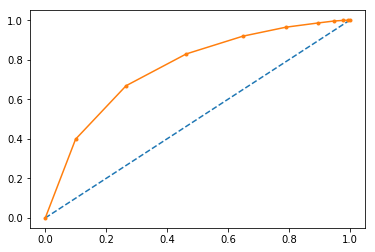

In [76]:
con_mat=knn_results(optimum_k,'kd_tree',tfidf_sent_vectors,tfidf_test_sent_vectors,y_1,y_test)

Observation: My model predicted with auc 0.759.

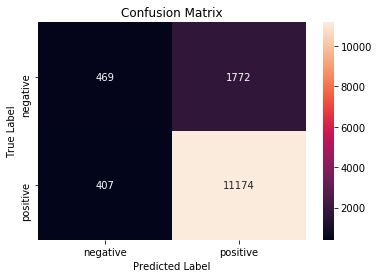

In [77]:
showHeatMap(con_mat)

Observation : 407 + 1772 points classifed wrongly.

# [6] Conclusions

| Method | No of samples | Algorithm | k value | accuray | AUC Score |
| --- | --- | --- | --- | --- | --- | --- |
| BOW | 50000 | brute | 5 | 83 | 0.645 |
| BOW | 50000 | kd_tree | 7 | 83 | 0.729 |
| TF-IDF | 50000 | brute | 3 | 83 | 0.509 |
| TF-IDF | 50000 | kd_tree | 3 | 83 | 0.595 |
| AVG W2VEC | 50000 | brute | 7 | 82 | 0.696 |
| AVG W2VEC | 50000 | kd_tree | 7 | 83 | 0.695 |
| TF_IDF AVG W2VEC | 50000 | brute | 7 | 84 | 0.746 |
| TF_IDF AVG W2VEC | 50000 | kd_tree | 9 | 84 | 0.759 |